In [136]:
#　必要なライブラリのインポート
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn as skl
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss


In [137]:
print("pandas:",pd.__version__)
print("numpy:",np.__version__)
print("xgboost:",xgb.__version__)
print("sklearn:",skl.__version__)


pandas: 2.2.2
numpy: 1.26.4
xgboost: 2.1.1
sklearn: 1.4.2


In [138]:
# データの読み込み
train_df = pd.read_csv(r"C:\Users\20222305\ILLARTS_Works\Python\PK\Practice_Kaggle\kaggle-sf-crime\data\train.csv")
test_df = pd.read_csv(r"C:\Users\20222305\ILLARTS_Works\Python\PK\Practice_Kaggle\kaggle-sf-crime\data\test.csv")


In [139]:
# データフレームの列名を確認
print(train_df.columns)
print(test_df.columns)

Index(['Dates', 'Category', 'Descript', 'DayOfWeek', 'PdDistrict',
       'Resolution', 'Address', 'X', 'Y'],
      dtype='object')
Index(['Id', 'Dates', 'DayOfWeek', 'PdDistrict', 'Address', 'X', 'Y'], dtype='object')


In [140]:
# データフレームを確認
display(train_df)

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


In [141]:
display(test_df)

,Id,Dates,DayOfWeek,PdDistrict,Address,X,Y
0,0,2015-05-10 23:59:00,Sunday,BAYVIEW,2000 Block of THOMAS AV,-122.399588,37.735051
1,1,2015-05-10 23:51:00,Sunday,BAYVIEW,3RD ST / REVERE AV,-122.391523,37.732432
2,2,2015-05-10 23:50:00,Sunday,NORTHERN,2000 Block of GOUGH ST,-122.426002,37.792212
3,3,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
4,4,2015-05-10 23:45:00,Sunday,INGLESIDE,4700 Block of MISSION ST,-122.437394,37.721412
...,...,...,...,...,...,...,...
884257,884257,2003-01-01 00:01:00,Wednesday,MISSION,2600 Block of BRYANT ST,-122.408983,37.751987
884258,884258,2003-01-01 00:01:00,Wednesday,NORTHERN,1900 Block of WASHINGTON ST,-122.425342,37.792681
884259,884259,2003-01-01 00:01:00,Wednesday,INGLESIDE,5500 Block of MISSION ST,-122.445418,37.712075
884260,884260,2003-01-01 00:01:00,Wednesday,BAYVIEW,1500 Block of HUDSON AV,-122.387394,37.739479


In [142]:
# トレーニングデータの重複項目の削除
train_df.duplicated().sum()
shape_before= train_df.shape


In [143]:
# トレーニングデータの重複項目の統合
train_df.drop_duplicates(keep="first", inplace=True)
# https://note.nkmk.me/python-pandas-duplicated-drop-duplicates/#drop_duplicates


shape_after= train_df.shape

#重複項目削除前
print(shape_before)

#重複項目削除後
print(shape_after)


(878049, 9)
(875726, 9)


In [144]:
train_df=train_df.query('Y != 90')


In [145]:
df = pd.DataFrame(train_df)

# 各カテゴリの件数を計算
category_counts = df['Category'].value_counts()

# 全体の件数を計算
total_count = len(df)

# カテゴリごとの発生比率を計算
category_ratios = category_counts / total_count

# 結果をデータフレームとして表示
result_df = category_ratios.reset_index()
result_df.columns = ['Category', 'Frequency']


display(result_df)


,Category,Frequency
0,LARCENY/THEFT,0.199056
1,OTHER OFFENSES,0.143827
2,NON-CRIMINAL,0.104962
3,ASSAULT,0.087718
4,DRUG/NARCOTIC,0.061575
5,VEHICLE THEFT,0.061322
6,VANDALISM,0.050910
7,WARRANTS,0.048120
8,BURGLARY,0.041796
9,SUSPICIOUS OCC,0.035850


In [146]:
under_one_percent_category = list(result_df.loc[result_df['Frequency'] < 0.01, 'Category'])


In [147]:
# 特定のカテゴリを削除
will_deleat=[
 'WEAPON LAWS',
 'PROSTITUTION',
 'TRESPASS',
 'STOLEN PROPERTY',
 'SEX OFFENSES FORCIBLE',
 'DISORDERLY CONDUCT',
 'DRUNKENNESS',
 'RECOVERED VEHICLE',
 'KIDNAPPING',
 'DRIVING UNDER THE INFLUENCE',
 'RUNAWAY',
 'LIQUOR LAWS',
 'ARSON',
 'LOITERING',
 'EMBEZZLEMENT',
 'SUICIDE',
 'FAMILY OFFENSES',
 'BAD CHECKS',
 'BRIBERY',
 'EXTORTION',
 'SEX OFFENSES NON FORCIBLE',
 'GAMBLING',
 'PORNOGRAPHY/OBSCENE MAT',
 'TREA'
]


# train.drop(columns=will_deleat, inplace=True)


train_reduced_categories = train_df.loc[train_df['Category'].isin(will_deleat)]
train_reduced_categories.shape


(58501, 9)

In [148]:
#インデックスの再割り振り
train_reset_index = train_reduced_categories.reset_index(drop=True)

display(train_reset_index.head())
display(train_reset_index.tail())

# https://note.nkmk.me/python-pandas-reset-index/


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 20:29:00,WEAPON LAWS,SUSPICIOUS PACKAGE,Wednesday,TARAVAL,NONE,1400 Block of HOLLOWAY AV,-122.473182,37.721565
1,2015-05-13 19:26:00,DRUNKENNESS,UNDER INFLUENCE OF ALCOHOL IN A PUBLIC PLACE,Wednesday,CENTRAL,NONE,900 Block of BUSH ST,-122.412929,37.789687
2,2015-05-13 18:42:00,WEAPON LAWS,EXHIBITING DEADLY WEAPON IN A THREATING MANNER,Wednesday,NORTHERN,NONE,1900 Block of POLK ST,-122.421427,37.794603
3,2015-05-13 17:47:00,STOLEN PROPERTY,"STOLEN PROPERTY, POSSESSION WITH KNOWLEDGE, RE...",Wednesday,BAYVIEW,NONE,0 Block of WHITFIELD CT,-122.381838,37.731104
4,2015-05-13 17:27:00,TRESPASS,TRESPASSING,Wednesday,TENDERLOIN,NONE,100 Block of EDDY ST,-122.410135,37.784189


,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
58496,2003-01-06 05:20:00,TRESPASS,TRESPASSING,Monday,SOUTHERN,"ARREST, CITED",900 Block of MARKET ST,-122.409537,37.782691
58497,2003-01-06 05:08:00,STOLEN PROPERTY,RECEIVING STOLEN PROPERTY,Monday,INGLESIDE,"ARREST, BOOKED",800 Block of MOULTRIE ST,-122.416162,37.734230
58498,2003-01-06 03:33:00,STOLEN PROPERTY,RECEIVING STOLEN PROPERTY,Monday,NORTHERN,"ARREST, BOOKED",POST ST / POLK ST,-122.419930,37.786826
58499,2003-01-06 01:54:00,SEX OFFENSES FORCIBLE,"FORCIBLE RAPE, BODILY FORCE",Monday,TENDERLOIN,"ARREST, BOOKED",1400 Block of GOLDEN GATE AV,-122.434423,37.779193
58500,2003-01-06 01:30:00,TRESPASS,TRESPASSING,Monday,RICHMOND,"ARREST, CITED",1000 Block of 22ND AV,-122.391668,37.757793


In [149]:
train_df = train_reset_index

In [150]:
# カテゴリカルデータのエンコード

# LabelEncoder()は，文字列や数値で表されたラベルを，0~(ラベル種類数-1)までの数値に変換してくれるものです．
# 機械学習で分類系のタスクを扱う場合，正解のラベルが文字列で表されることはよくあります．
# このようなとき，LabelEncoder()を使うと簡単に数値に変換できるという感じです．
# https://gotutiyan.hatenablog.com/entry/2020/09/08/122621#fit_transform

label_encoder = LabelEncoder()

# fit_transform()
    # fit()とtransform()を一気に行う場合，fit_transform()を使うと楽です．
    # 入力がラベルの一次元リスト，出力がラベルIDの一次元リストになっています．

        # fit()
            # まずは，ラベルとラベルIDの対応づけを行います．
            # positiveは0にしよう，みたいなことを決めるのです．
            # これはle.fit(ラベルの一次元リスト)で行います．

        # transform() (ラベル→ラベルID)
            # ラベルとラベルIDの対応づけができれば，それに従って変換することができます．
            # これはtransform(ラベルの一次元リスト)で行います．
            # fitはle.fit()を書くだけですが，transformはhoge = le.transform()のように返り値を保存する必要があります．

train_df['Category'] = label_encoder.fit_transform(train_df['Category'])



In [151]:
# Categoryが数値に置き換わっている
display(train_df)

train_df.dtypes

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 20:29:00,23,SUSPICIOUS PACKAGE,Wednesday,TARAVAL,NONE,1400 Block of HOLLOWAY AV,-122.473182,37.721565
1,2015-05-13 19:26:00,5,UNDER INFLUENCE OF ALCOHOL IN A PUBLIC PLACE,Wednesday,CENTRAL,NONE,900 Block of BUSH ST,-122.412929,37.789687
2,2015-05-13 18:42:00,23,EXHIBITING DEADLY WEAPON IN A THREATING MANNER,Wednesday,NORTHERN,NONE,1900 Block of POLK ST,-122.421427,37.794603
3,2015-05-13 17:47:00,19,"STOLEN PROPERTY, POSSESSION WITH KNOWLEDGE, RE...",Wednesday,BAYVIEW,NONE,0 Block of WHITFIELD CT,-122.381838,37.731104
4,2015-05-13 17:27:00,22,TRESPASSING,Wednesday,TENDERLOIN,NONE,100 Block of EDDY ST,-122.410135,37.784189
...,...,...,...,...,...,...,...,...,...
58496,2003-01-06 05:20:00,22,TRESPASSING,Monday,SOUTHERN,"ARREST, CITED",900 Block of MARKET ST,-122.409537,37.782691
58497,2003-01-06 05:08:00,19,RECEIVING STOLEN PROPERTY,Monday,INGLESIDE,"ARREST, BOOKED",800 Block of MOULTRIE ST,-122.416162,37.734230
58498,2003-01-06 03:33:00,19,RECEIVING STOLEN PROPERTY,Monday,NORTHERN,"ARREST, BOOKED",POST ST / POLK ST,-122.419930,37.786826
58499,2003-01-06 01:54:00,17,"FORCIBLE RAPE, BODILY FORCE",Monday,TENDERLOIN,"ARREST, BOOKED",1400 Block of GOLDEN GATE AV,-122.434423,37.779193


Dates          object
Category        int32
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

In [152]:
# 特徴量とラベルの分割を行う

# 説明変数
X = train_df.drop(columns=['Category', 'Descript', 'Resolution', 'Address', 'Dates'])

# 目的変数
y = train_df['Category']


In [153]:
display(X)
X.dtypes

,DayOfWeek,PdDistrict,X,Y
0,Wednesday,TARAVAL,-122.473182,37.721565
1,Wednesday,CENTRAL,-122.412929,37.789687
2,Wednesday,NORTHERN,-122.421427,37.794603
3,Wednesday,BAYVIEW,-122.381838,37.731104
4,Wednesday,TENDERLOIN,-122.410135,37.784189
...,...,...,...,...
58496,Monday,SOUTHERN,-122.409537,37.782691
58497,Monday,INGLESIDE,-122.416162,37.734230
58498,Monday,NORTHERN,-122.419930,37.786826
58499,Monday,TENDERLOIN,-122.434423,37.779193


DayOfWeek      object
PdDistrict     object
X             float64
Y             float64
dtype: object

In [154]:
display(y)
y.dtypes

0        23
1         5
2        23
3        19
4        22
         ..
58496    22
58497    19
58498    19
58499    17
58500    22
Name: Category, Length: 58501, dtype: int32

dtype('int32')

In [155]:
# DateTimeの分割
X['Year'] = pd.to_datetime(train_df['Dates']).dt.year
X['Month'] = pd.to_datetime(train_df['Dates']).dt.month
X['Day'] = pd.to_datetime(train_df['Dates']).dt.day
X['Hour'] = pd.to_datetime(train_df['Dates']).dt.hour

In [156]:
display(X)
X.dtypes

,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour
0,Wednesday,TARAVAL,-122.473182,37.721565,2015,5,13,20
1,Wednesday,CENTRAL,-122.412929,37.789687,2015,5,13,19
2,Wednesday,NORTHERN,-122.421427,37.794603,2015,5,13,18
3,Wednesday,BAYVIEW,-122.381838,37.731104,2015,5,13,17
4,Wednesday,TENDERLOIN,-122.410135,37.784189,2015,5,13,17
...,...,...,...,...,...,...,...,...
58496,Monday,SOUTHERN,-122.409537,37.782691,2003,1,6,5
58497,Monday,INGLESIDE,-122.416162,37.734230,2003,1,6,5
58498,Monday,NORTHERN,-122.419930,37.786826,2003,1,6,3
58499,Monday,TENDERLOIN,-122.434423,37.779193,2003,1,6,1


DayOfWeek      object
PdDistrict     object
X             float64
Y             float64
Year            int32
Month           int32
Day             int32
Hour            int32
dtype: object

In [162]:
# カテゴリカルデータのエンコード（トレーニングデータ）
label_encoder_dayofweek = LabelEncoder()
label_encoder_pddistrict = LabelEncoder()

# トレーニングデータでfit
X['DayOfWeek'] = label_encoder_dayofweek.fit_transform(X['DayOfWeek'])
X['PdDistrict'] = label_encoder_pddistrict.fit_transform(X['PdDistrict'])

In [163]:
# エンコード後のデータ
# DayOfWeekとPdDistrictが数値に変化している	

display(X)
X.dtypes


,DayOfWeek,PdDistrict,X,Y,Year,Month,Day,Hour
0,6,8,-122.473182,37.721565,2015,5,13,20
1,6,1,-122.412929,37.789687,2015,5,13,19
2,6,4,-122.421427,37.794603,2015,5,13,18
3,6,0,-122.381838,37.731104,2015,5,13,17
4,6,9,-122.410135,37.784189,2015,5,13,17
...,...,...,...,...,...,...,...,...
58496,1,7,-122.409537,37.782691,2003,1,6,5
58497,1,2,-122.416162,37.734230,2003,1,6,5
58498,1,4,-122.419930,37.786826,2003,1,6,3
58499,1,9,-122.434423,37.779193,2003,1,6,1


DayOfWeek       int32
PdDistrict      int32
X             float64
Y             float64
Year            int32
Month           int32
Day             int32
Hour            int32
dtype: object

In [164]:
# ラベルの範囲を確認
num_classes = len(np.unique(y))
print(f'Number of classes: {num_classes}')
print(f'Label range: {y.min()} to {y.max()}')

Number of classes: 24
Label range: 0 to 23


In [165]:
# X = X.drop(columns=['Dates'])
# 訓練データと検証データに分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [166]:
# XGBoostのDMatrixの作成
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

In [167]:
evals_result = {}

# パラメータの設定
params = {
    'objective': 'multi:softprob',
    'num_class': num_classes,
    'eval_metric': 'mlogloss',
    'max_depth': 6,
    'eta': 0.3,
    'subsample': 0.8,
    'colsample_bytree': 0.8

}

# モデルの訓練
evallist = [(dval, 'eval'), (dtrain, 'train')]
num_round = 60
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10, evals_result=evals_result)


C:\Users\20222305\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:723: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	eval-mlogloss:2.76528	train-mlogloss:2.73027
[1]	eval-mlogloss:2.59298	train-mlogloss:2.54263
[2]	eval-mlogloss:2.49291	train-mlogloss:2.42728
[3]	eval-mlogloss:2.41056	train-mlogloss:2.33062
[4]	eval-mlogloss:2.35130	train-mlogloss:2.26076
[5]	eval-mlogloss:2.30430	train-mlogloss:2.20268
[6]	eval-mlogloss:2.26654	train-mlogloss:2.15322
[7]	eval-mlogloss:2.23733	train-mlogloss:2.11289
[8]	eval-mlogloss:2.21377	train-mlogloss:2.07834
[9]	eval-mlogloss:2.19530	train-mlogloss:2.04774
[10]	eval-mlogloss:2.17955	train-mlogloss:2.02202
[11]	eval-mlogloss:2.16619	train-mlogloss:1.99782
[12]	eval-mlogloss:2.15618	train-mlogloss:1.97688
[13]	eval-mlogloss:2.14768	train-mlogloss:1.95760
[14]	eval-mlogloss:2.14025	train-mlogloss:1.94035
[15]	eval-mlogloss:2.13251	train-mlogloss:1.92330
[16]	eval-mlogloss:2.12637	train-mlogloss:1.90840
[17]	eval-mlogloss:2.11936	train-mlogloss:1.89247
[18]	eval-mlogloss:2.11587	train-mlogloss:1.87884
[19]	eval-mlogloss:2.11197	train-mlogloss:1.86590
[20]	eval-

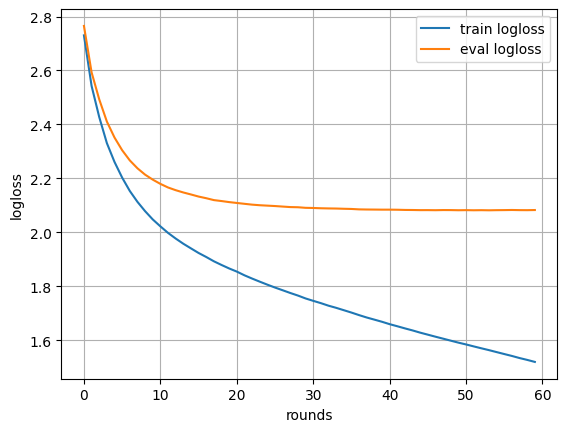

Minimum eval-mlogloss: 2.081555108460883 at iteration 53


In [168]:
import matplotlib.pyplot as plt

# --- 学習結果をグラフで描画 ---
train_metric = evals_result['train']['mlogloss']
plt.plot(train_metric, label='train logloss')
eval_metric = evals_result['eval']['mlogloss']
plt.plot(eval_metric, label='eval logloss')
plt.grid()
plt.legend()
plt.xlabel('rounds')
plt.ylabel('logloss')
plt.show()


# 'eval'データセットでのeval-mloglossの履歴を取得
eval_mlogloss_values = evals_result['eval']['mlogloss']

# 最小のeval-mloglossとその時のイテレーションを取得
min_eval_mlogloss = min(eval_mlogloss_values)
best_iteration = eval_mlogloss_values.index(min_eval_mlogloss)

print(f"Minimum eval-mlogloss: {min_eval_mlogloss} at iteration {best_iteration}")


In [169]:
# 検証データで予測
y_pred_proba = bst.predict(dval)


In [171]:
# テストデータの準備
# DateTimeの分割
test_df['Year'] = pd.to_datetime(test_df['Dates']).dt.year
test_df['Month'] = pd.to_datetime(test_df['Dates']).dt.month
test_df['Day'] = pd.to_datetime(test_df['Dates']).dt.day
test_df['Hour'] = pd.to_datetime(test_df['Dates']).dt.hour

In [172]:
# テストデータにも同じエンコーダーを使ってtransform
test_df['DayOfWeek'] = label_encoder_dayofweek.transform(test_df['DayOfWeek'])
test_df['PdDistrict'] = label_encoder_pddistrict.transform(test_df['PdDistrict'])

In [181]:
# テストデータの特徴量を用意する
X_test = test_df[['DayOfWeek', 'PdDistrict', 'X', 'Y', 'Year', 'Month', 'Day', 'Hour']]

# DMatrix形式に変換
dtest = xgb.DMatrix(X_test)


In [182]:
# クラス名のリストを取得
class_names = label_encoder.classes_

In [183]:
# テストデータで予測
y_test_pred_proba = bst.predict(dtest)


In [184]:
# y_test_pred_probaの形状を確認
print("y_test_pred_proba shape:", y_test_pred_proba.shape)

# label_encoder_dayofweek.classes_の長さを確認
print("Number of classes:", len(label_encoder_dayofweek.classes_))



y_test_pred_proba shape: (884262, 24)
Number of classes: 7


In [185]:
# 提出用データフレームの作成
submission = pd.DataFrame(y_test_pred_proba, columns=class_names)

# 'Id' カラムの追加（テストデータのインデックスをIdとして使用）
submission['Id'] = test_df.index

# カラムの順序を'Id'を最初に移動
submission = submission[['Id'] + class_names.tolist()]

# CSVファイルとして保存
submission.to_csv('submission.csv', index=False)
